In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data Preprocessing

In [2]:
# apply the min-max scaling in Pandas using the .min() and .max() methods

def min_max_scaling(df):
    # copy the dataframe
    
    df_norm = df.copy()
    # apply min-max scaling
    
    for column in df_norm.columns:
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        
    return df_norm

# read the mainsample.dta file for further processing 

data = pd.io.stata.read_stata("data_candidates_mainsample.dta")
data.to_csv('data_candidates_mainsample.csv')

# Import the mainsample via StataReader to use variable_labels (old version of the read_stata)

data_stata = pd.io.stata.StataReader("data_candidates_mainsample.dta")
data_labels = data_stata.variable_labels()

# Remove all columns in the dataset for which no labels exist
# Those are mostly columns needed for p-tests and some matrix calculations in
# Stata. The outputted labels are those that are kept in the data

data = data.drop(columns=['CVAxORIGINE_IM_12', 'CVAxZUS_CUCS', 'CVAxZetI', 'C', 'CVA0',\
                          'p_offre1', 'control_manquant', 'ZouI_pred', 'ZouI0', 'ALE_16', 'CVA'])

# Remove sampling weights (within and out of the experiment)

data = data.drop(columns='POIDS_SEL')

# Remove all the centered features

data = data.drop(columns=['FEMME_c', 'a30m_c', 'a3049_c', 'a50p_c', 'dip_aucun_c',\
                          'dip_bepcap_c', 'dip_bac_c', 'dip_bac2p_c', 'recherche_LD_c', 'recherche_TLD_c'])

# Remove all features that are not directly derivable from the CVs or that have missing data

data = data.drop(columns=['RECRUTE', 'REFUSAL', 'codage_cv', 'ORIGINE_IM_1', 'ORIGINE_IM_2',\
                          'ORIGINE_IM_12', 'ID_OFFRE', 'ID_CANDIDAT', 'travail_etranger', 'duree_expro_offre'])

# Remove additional features that seem to bring no value or are unclear in the methodology according to the original paper

data = data.drop(columns=['CV_hesit_', 'CV_hesit', 'CV_note_7p', 'ZetI', 'permis', 'CV_attrayant_'])

# Remove CV coding feature: CV_qualif -> adequate skills 

# data = data.drop(columns=['CV_qualif'])

for key, value in data_labels.items():
    for col in data.columns:
        if key==col:
            # print(key, ':    ', value)
            if len(value)==0 or value.startswith('ID_OFFRE==') or value.startswith('Dummy for local job center'):
                data = data.drop(columns=col)

data['CV_qualif_sup'] = data['CV_qualif_sup'].fillna(0)
data['CV_qualif_inf'] = data['CV_qualif_inf'].fillna(0)
data['PREN_MUSULMAN'] = data['PREN_MUSULMAN'].fillna(0)
data['ZUS_CUCS'] = data['ZUS_CUCS'].fillna(0)
data['recherche_TLD'] = data['recherche_TLD'].fillna(0)

data['etudes_etranger'] = data['etudes_etranger'].fillna(0)
data['langue_anglais'] = data['langue_anglais'].fillna(0)
data['langue_arabe'] = data['langue_arabe'].fillna(0)
data['langue_autres'] = data['langue_autres'].fillna(0)
data['CV_formation_'] = data['CV_formation_'].fillna(0)

# derived from CV_experience_3p

data['CV_experience_'] = data['CV_experience_'].fillna(0.5)

# fill with 1 since missing records are not in the other age groups

data['a26m'] = data['a26m'].fillna(1)

# Assign medium grade for all unknown records
data['CV_note_2'] = data['CV_note_2'].fillna(0)
data['CV_note_3'] = data['CV_note_3'].fillna(1)
data['CV_note_4'] = data['CV_note_4'].fillna(0)
data['CV_note_5'] = data['CV_note_5'].fillna(0)

# Normalize remaining columns to values between 0 and 1
# call the min_max_scaling function

data = min_max_scaling(data)

In [118]:
data_fem = data[data['FEMME']==1]
data_male = data[data['FEMME']==0]

print('average female qualification score:', np.average(data_fem['CV_qualif']))
print('average male qualification score:', np.average(data_male['CV_qualif']))

print('%% of underqualified females: %.2f %%' %(sum(data_fem['CV_qualif_inf'])/data_fem.shape[0]*100))
print('%% of underqualified males: %.2f %%' %(sum(data_male['CV_qualif_inf'])/data_male.shape[0]*100))

print('%% of overqualified females: %.2f %%' %(sum(data_fem['CV_qualif_sup'])/data_fem.shape[0]*100))
print('%% of overqualified males: %.2f %%' %(sum(data_male['CV_qualif_sup'])/data_male.shape[0]*100))

interviewed_dict = {
    'females': data_fem[data_fem['ENTRETIEN']==1].shape[0],
    'males': data_male[data_male['ENTRETIEN']==1].shape[0]
}

m_f_dict = {
    'females': data_fem.shape[0],
    'males': data_male.shape[0]
}

quali_dict = {
    'females': np.average(data_fem['CV_qualif']),
    'males': np.average(data_male['CV_qualif'])
}

uncerquali_dict = {
    'females': sum(data_fem['CV_qualif_inf'])/data_fem.shape[0]*100,
    'males': sum(data_male['CV_qualif_inf'])/data_male.shape[0]*100
       }

overquali_dict = {
    'females': sum(data_fem['CV_qualif_sup'])/data_fem.shape[0]*100,
    'males': sum(data_male['CV_qualif_sup'])/data_male.shape[0]*100
}


average female qualification score: 0.54960024
average male qualification score: 0.5571409
% of underqualified females: 15.30 %
% of underqualified males: 17.79 %
% of overqualified females: 20.21 %
% of overqualified males: 15.66 %


In [44]:
print('correlation between underqualification in the dataset: %.2f' %data['CV_qualif_inf'].corr(data['ENTRETIEN']))
print('correlation between overqualification in the dataset: %.2f' %data['CV_qualif_sup'].corr(data['ENTRETIEN']))

correlation between underqualification in the dataset: -0.05
correlation between overqualification in the dataset: -0.04


(array([267.,   0.,   0.,   0.,   0., 190.,   0.,   0.,   0., 341.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

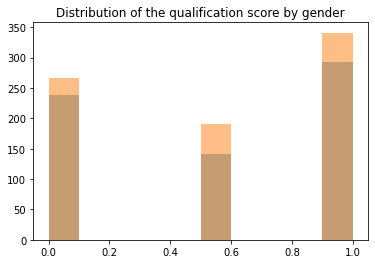

In [45]:
plt.title('Distribution of the qualification score by gender')
plt.hist(data_fem['CV_qualif'], alpha=.5)
plt.hist(data_male['CV_qualif'], alpha=.5)

ValueError: Invalid RGBA argument: 1

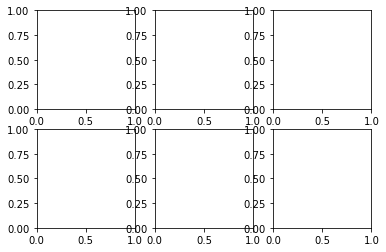

In [147]:
fig, axs = plt.subplots(2, 3)

axs[0, 0].bar(range(len(quali_dict)), list(quali_dict.values()), align='center', color=[1, 2])
axs[0, 0].set_xticklabels(['', 'female', '', 'male'])
axs[0, 0].set_title('average qualification score by gender')

axs[1, 0].hist(data_fem['CV_qualif'], alpha=.5)
axs[1, 0].hist(data_male['CV_qualif'], alpha=.5)
axs[1, 0].set_title('Distribution of the qualification score by gender')

axs[0, 1].bar(range(len(uncerquali_dict)), list(uncerquali_dict.values()), align='center')
axs[0, 1].set_xticklabels(['', 'female', '', 'male'])
axs[0, 1].set_title('% of underqualified applicants by gender')

axs[1, 1].bar(range(len(overquali_dict)), list(overquali_dict.values()), align='center')
axs[1, 1].set_xticklabels(['', 'female', '', 'male'])
axs[1, 1].set_title('% of overqualified applicants by gender')

axs[0, 2].bar(range(len(m_f_dict)), list(m_f_dict.values()), align='center')
axs[0, 2].set_xticklabels(['', 'female', '', 'male'])
axs[0, 2].set_title('# of female and male datapoints')



axs[1, 2].bar(range(len(interviewed_dict)), list(interviewed_dict.values()), align='center')
axs[1, 2].set_title('# of interviewed female and male datapoints')



plt.subplots_adjust(left=-0.9, bottom=None, right=None, top=None, wspace=0.5, hspace=.50)

([<matplotlib.axis.XTick at 0x1b3b50eaee0>,
 [Text(0, 0, 'females'), Text(1, 0, 'males')])

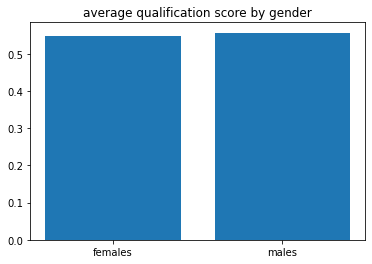

In [46]:
plt.title('average qualification score by gender')
plt.bar(range(len(quali_dict)), list(quali_dict.values()), align='center')
plt.xticks(range(len(quali_dict)), list(quali_dict.keys()))

([<matplotlib.axis.XTick at 0x1b3b51399d0>,
 [Text(0, 0, 'females'), Text(1, 0, 'males')])

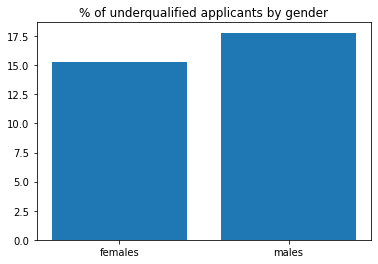

In [47]:
plt.title('% of underqualified applicants by gender')
plt.bar(range(len(uncerquali_dict)), list(uncerquali_dict.values()), align='center')
plt.xticks(range(len(uncerquali_dict)), list(uncerquali_dict.keys()))

([<matplotlib.axis.XTick at 0x1b3b518bf10>,
 [Text(0, 0, 'females'), Text(1, 0, 'males')])

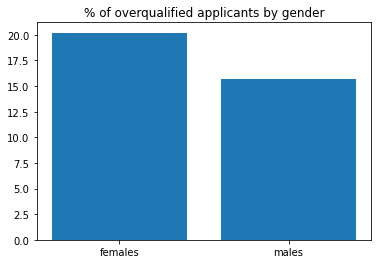

In [48]:
plt.title('% of overqualified applicants by gender')
plt.bar(range(len(overquali_dict)), list(overquali_dict.values()), align='center')
plt.xticks(range(len(overquali_dict)), list(overquali_dict.keys()))

**Observation**: The distribution of qualification score is very similar for both genders as well as the average qualification score.
On the other side there are more underqualified male and more overqualified females. Both features under and overqualified are shown to be negatively correlated with our label.

From those observations we can state that the qualification score can be used as a control measure for our work since it is balance for both genders

([<matplotlib.axis.XTick at 0x1b3b52354c0>,
 [Text(0, 0, 'females'), Text(1, 0, 'males')])

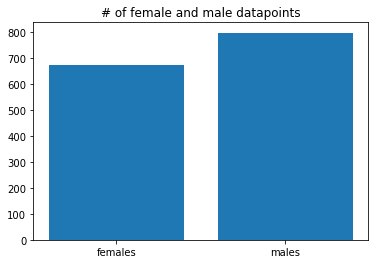

In [50]:
plt.title('# of female and male datapoints')
plt.bar(range(len(m_f_dict)), list(m_f_dict.values()), align='center')
plt.xticks(range(len(m_f_dict)), list(m_f_dict.keys()))

In [8]:
data_male['CV_qualif_inf']

2       0.0
3       0.0
4       0.0
6       0.0
8       0.0
       ... 
1462    0.0
1463    0.0
1464    0.0
1465    0.0
1466    0.0
Name: CV_qualif_inf, Length: 798, dtype: float32

# Summary Bias


# DATA1


In [9]:
data = data.fillna(0)
data[47:58]

,ENTRETIEN,PREN_MUSULMAN,ZUS_CUCS,ZouI,FEMME,a50p,a3049,a26m,dip_aucun,dip_bepcap,...,service_nm,service_m,industrie,construction,cadre,profint,eoq,CDI,CNT_sup6m,poste_unique
47,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
48,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
49,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
51,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
52,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
53,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
54,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
55,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
56,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0


0.02351733666443846

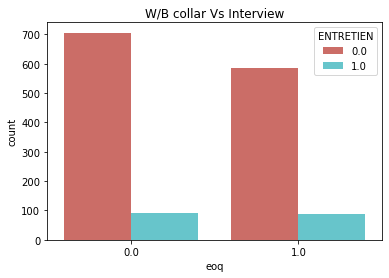

In [10]:
#skilled while/blue collar
sns.countplot(x='eoq', hue = 'ENTRETIEN', data=data, palette='hls').set_title('W/B collar Vs Interview')
data['eoq'].corr(data['ENTRETIEN'])

In [11]:
data['dip_bepcap'].corr(data['ENTRETIEN'])

0.0033971508124601103

In [12]:
data['dip_bac'].corr(data['ENTRETIEN'])

-0.00552348358809926

In [13]:
data['dip_bac2p'].corr(data['ENTRETIEN'])

0.005445896126693376

In [14]:
data['dip_bac2'].corr(data['ENTRETIEN'])

0.007520195930698823

Text(0.5, 0.98, '3yr after school Vs Interview')

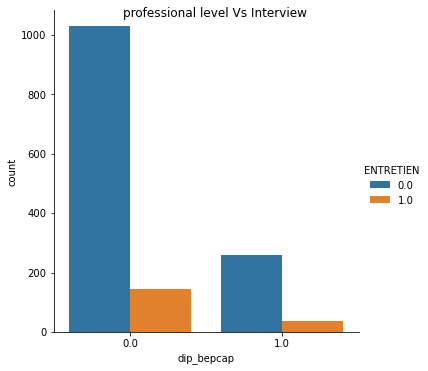

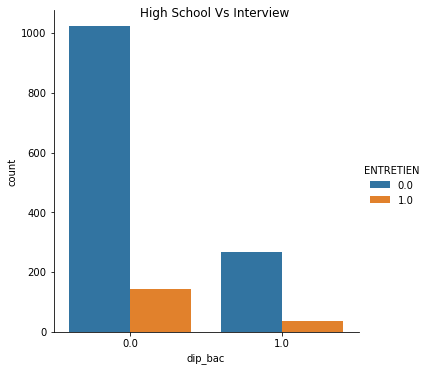

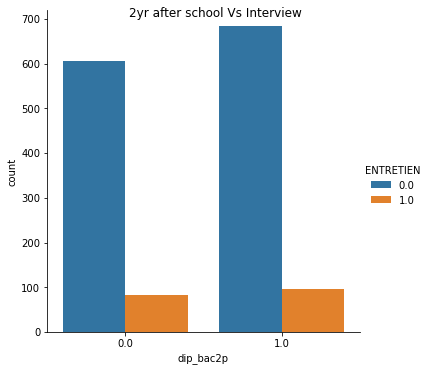

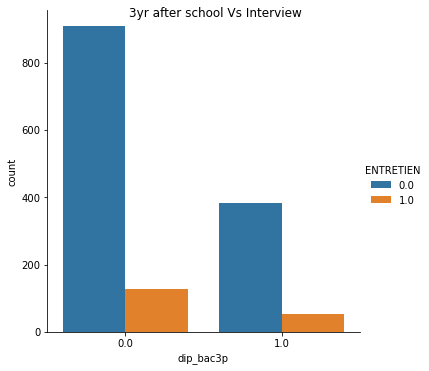

In [15]:
#professions
#data1['dip_bepcap'] professional
#data1['dip_bac'] high school
#data1['dip_bac2p'] upper education
#data1['dip_bac2']diploma 2 years after school
#data1['dip_bac3p'] diploma 3 years after school


sns.catplot(x = "dip_bepcap",hue = 'ENTRETIEN', kind = "count", data = data).fig.suptitle('professional level Vs Interview')
sns.catplot(x = "dip_bac", hue = 'ENTRETIEN', kind = "count", data = data).fig.suptitle('High School Vs Interview')
sns.catplot(x = "dip_bac2p", hue = 'ENTRETIEN',kind = "count", data = data).fig.suptitle('2yr after school Vs Interview')
sns.catplot(x = "dip_bac3p", hue = 'ENTRETIEN',kind = "count", data = data).fig.suptitle('3yr after school Vs Interview')
                                                                                                                                                                          
                                                                                         

In [16]:
x = data['FEMME']; y = data['ENTRETIEN']
x.corr(y)
y.corr(x)

0.02768127530591538

Text(0.5, 0.98, 'gender Vs Interview')

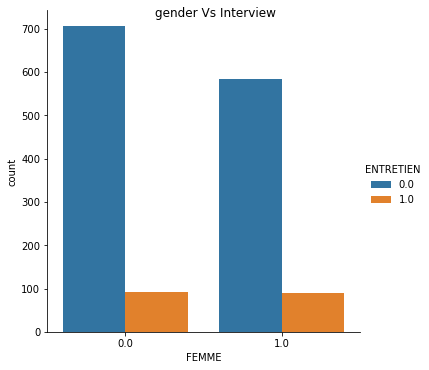

In [17]:
#gender
data['FEMME']
sns.catplot(x = "FEMME", hue = 'ENTRETIEN', kind = "count", data = data).fig.suptitle('gender Vs Interview')

Text(0.5, 0.98, 'below 26 yrs')

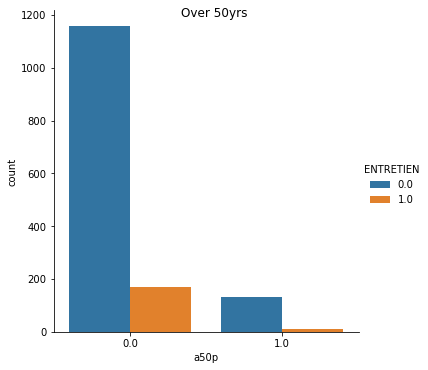

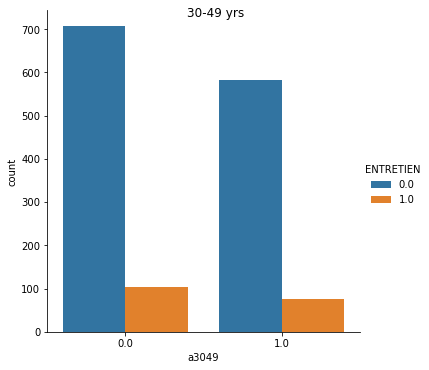

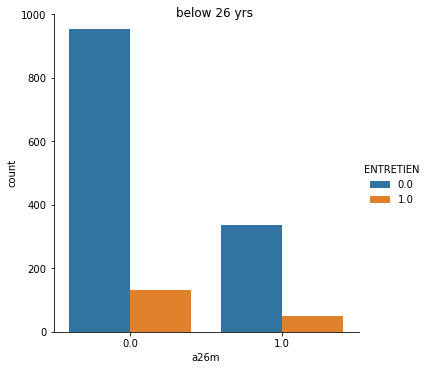

In [18]:
#age

sns.catplot(x = "a50p", hue = 'ENTRETIEN', kind = "count", data = data).fig.suptitle('Over 50yrs')
sns.catplot(x = "a3049", hue = 'ENTRETIEN', kind = "count", data = data).fig.suptitle('30-49 yrs')
sns.catplot(x = "a26m", hue = 'ENTRETIEN', kind = "count", data = data).fig.suptitle('below 26 yrs')


In [19]:
#race
data['PREN_MUSULMAN'] #muslim sound name
data['ORIGINE_IM_1'] #immigrant
data['ORIGINE_IM_2']#immigrant child
data['ORIGINE_IM_12'] #immigrant or immigrant child
data['ZUS_CUCS'] #Depried neighbour

sns.catplot(x = "PREN_MUSULMAN", hue = 'ENTRETIEN', kind = "count", data = data)
sns.catplot(x = "ORIGINE_IM_1", hue = 'ENTRETIEN', kind = "count", data = data)
sns.catplot(x = "ORIGINE_IM_2", hue = 'ENTRETIEN', kind = "count", data = data)
sns.catplot(x = "ZUS_CUCS", hue = 'ENTRETIEN', kind = "count", data = data)


KeyError: 'ORIGINE_IM_1'

In [ ]:
#language
data['langue_anglais']
data['langue_arabe']
data['langue_autres']

sns.catplot(x = "langue_anglais", hue = 'ENTRETIEN', kind = "count", data = data)
sns.catplot(x = "langue_autres", hue = 'ENTRETIEN', kind = "count", data = data)

In [ ]:
data['permis'] #driving license
sns.catplot(x = "permis", hue = 'ENTRETIEN', kind = "count", data = data).fig.suptitle('Driving Licence Vs Interview')
data['permis'].corr(data['ENTRETIEN'])